In [1]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


In [7]:
import os
import glob
import datetime
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
TRAIN_DIR = '/kaggle/input/covid-19-x-rays-images/train/'
VAL_DIR = '/kaggle/input/covid-19-x-rays-images/val/'
TEST_DIR = '/kaggle/input/covid-19-x-rays-images/test/'

In [ ]:
non_covid = glob.glob(f"{os.path.join(TRAIN_DIR, '0')}/*.png")[:4]
covid =  glob.glob(f"{os.path.join(TRAIN_DIR, '1')}/*.png")[:4]

### Non-Covid Images

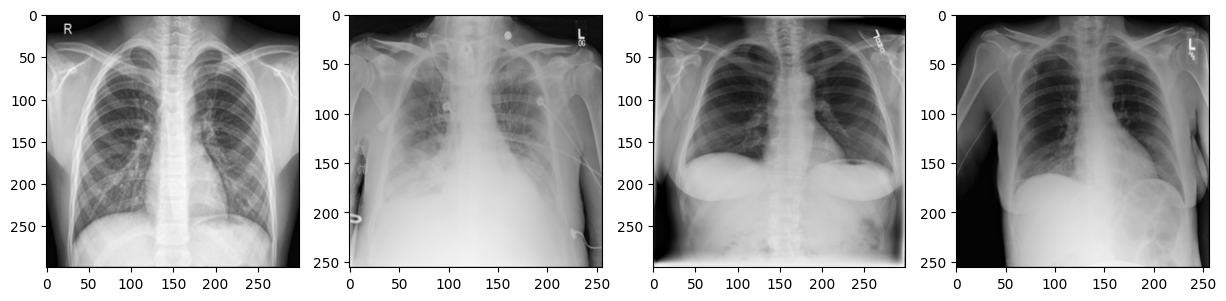

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), ncols=4, nrows=1)
ax = ax.flatten()
for i in range(4):
    img = cv2.imread(non_covid[i])
    ax[i].imshow(img)

### Covid Images

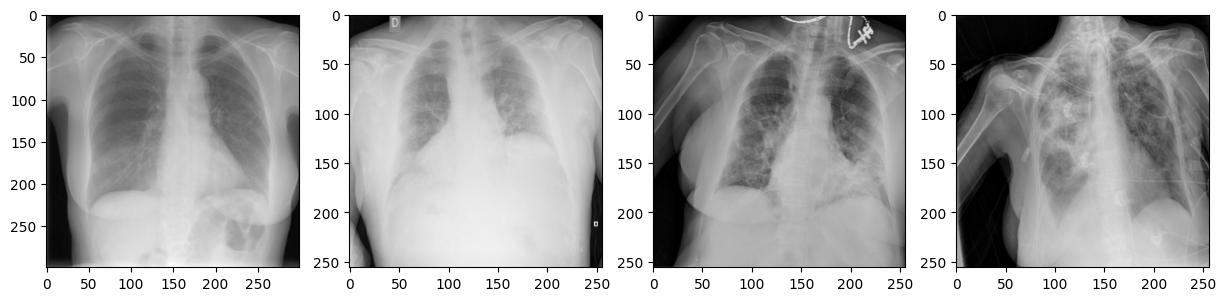

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), ncols=4, nrows=1)
ax = ax.flatten()
for i in range(4):
    img = cv2.imread(covid[i])
    ax[i].imshow(img)

### Parameters

In [8]:
# Initialize
LR = 1e-3
EPOCHS = 20
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)

### Data Augmentation

In [ ]:
# create data generators with image augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=TARGET_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode='binary'
                                                   )

Found 7000 images belonging to 2 classes.


In [ ]:
# create data generators with image augmentation for validation
val_datagen = ImageDataGenerator(rescale=1./255.0)

val_generator = val_datagen.flow_from_directory(VAL_DIR,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary'
                                               )

Found 1500 images belonging to 2 classes.


## Build the model

In [ ]:
def build_model():
    # load Xception model and ensuring the head FC layer sets are left off.
    base_model = tf.keras.applications.Xception(weights="imagenet",
                                          include_top=False,
                                          input_shape=(224,224, 3))

    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # construct the head of the model that will be placed on top the above of base model
    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

In [2]:
def tune_learning_rate(model):

  # set learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-8 * 10 ** (epoch/10))

  # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss='binary_crossentropy',
          metrics=['accuracy'])

    history = model.fit(train_generator,
                        epochs=100,
                        callbacks=[lr_schedule])

    return history

In [ ]:
# build the model
model_tune = build_model()
lr_history = tune_learning_rate(model_tune)

83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/100
110/110 [==============================] - 164s 1s/step - loss: 0.7112 - accuracy: 0.4969 - lr: 1.0000e-08
Epoch 2/100
110/110 [==============================] - 110s 998ms/step - loss: 0.7097 - accuracy: 0.5009 - lr: 1.2589e-08
Epoch 3/100
110/110 [==============================] - 110s 999ms/step - loss: 0.7105 - accuracy: 0.4989 - lr: 1.5849e-08
Epoch 4/100
110/110 [==============================] - 111s 1s/step - loss: 0.7095 - accuracy: 0.4990 - lr: 1.9953e-08
Epoch 5/100
110/110 [==============================] - 109s 992ms/step - loss: 0.7082 - accuracy: 0.5043 - lr: 2.5119e-08
Epoch 6/100
110/110 [==============================] - 108s 983ms/step - loss: 0.7073 - accuracy: 0.5020 - lr: 3.1623e-08
Epoch 7/100
110/110 [==============================] - 108s 985ms/step - loss: 0.7064 - accuracy: 0.5023 - lr: 3.9811e-08
Epoch 8/100
110/110 [==============================] - 106s 963ms/step - loss: 0.7057 -

In [ ]:
def plot_learning_rate(history):
    plt.figure(figsize=(10,6))
    plt.semilogx(history.history['lr'][:70], history.history['loss'][20:70])
    plt.tick_params('both', length=10, width=1, which='both')

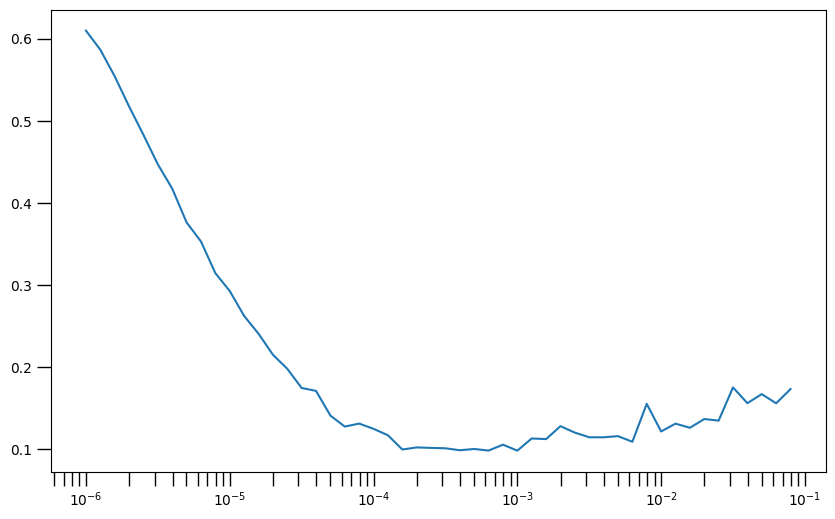

In [ ]:
plot_learning_rate(lr_history)

In [3]:
# set learning rate parameter
LR = 3e-4

## Train and compile the model

In [ ]:
def compile_model(model):
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
      loss='binary_crossentropy',
      metrics=['accuracy'])

    # define callbacks
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                             patience=5,
                                             verbose=1,
                                             mode='max',
                                             restore_best_weights=True)

    # Fit the model
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=30,
                        callbacks=earlystop)

    return history

In [ ]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 22,960,681
Trainable params: 13,729,513
Non-trainable params: 9,231,168
__________________________________

In [ ]:
model = build_model()
history = compile_model(model)

Epoch 1/30
110/110 [==============================] - 140s 1s/step - loss: 0.3259 - accuracy: 0.8566 - val_loss: 0.2581 - val_accuracy: 0.8933
Epoch 2/30
110/110 [==============================] - 118s 1s/step - loss: 0.2007 - accuracy: 0.9164 - val_loss: 0.1580 - val_accuracy: 0.9380
Epoch 3/30
110/110 [==============================] - 117s 1s/step - loss: 0.1437 - accuracy: 0.9400 - val_loss: 0.6039 - val_accuracy: 0.8433
Epoch 4/30
110/110 [==============================] - 118s 1s/step - loss: 0.1312 - accuracy: 0.9480 - val_loss: 0.1677 - val_accuracy: 0.9393
Epoch 5/30
110/110 [==============================] - 118s 1s/step - loss: 0.1002 - accuracy: 0.9596 - val_loss: 0.1855 - val_accuracy: 0.9420
Epoch 6/30
110/110 [==============================] - 118s 1s/step - loss: 0.0927 - accuracy: 0.9649 - val_loss: 0.1555 - val_accuracy: 0.9460
Epoch 7/30
110/110 [==============================] - 118s 1s/step - loss: 0.0737 - accuracy: 0.9723 - val_loss: 0.1235 - val_accuracy: 0.9553

## Model Evaluation

In [ ]:
def plot(history, string, y):
    plt.plot(history.history[string], label='training')
    plt.plot(history.history[f'val_{string}'], label='validation')
    plt.xlabel('Epoch')
    plt.ylabel(string)
    plt.ylim(y)
    plt.title(f'model {string}')
    plt.legend(loc='upper left')
    plt.savefig(f"/kaggle/working/models/model_{string}.png");

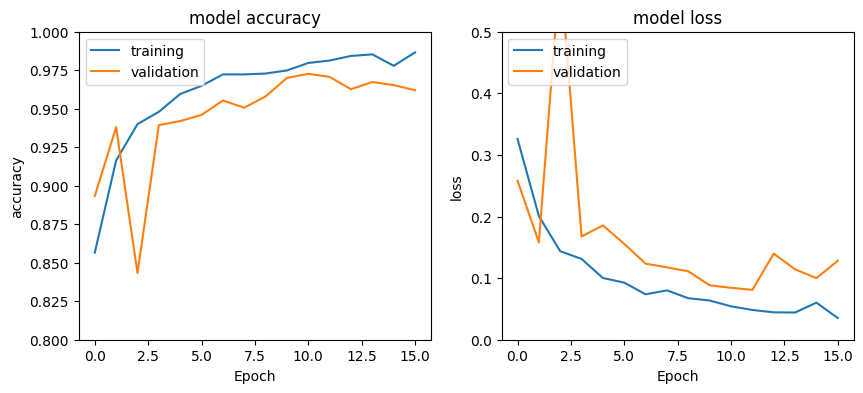

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plot(history, 'accuracy', y=(0.8, 1.0))
plt.subplot(1,2,2)
plot(history, 'loss', y=(0, 0.5))

## Save Model

In [ ]:
timestamp = datetime.date.today()
file_path = os.path.join('/kaggle/working/models', f'{str(timestamp)}_xception.h5')
model.save(file_path)

## Inference

In [ ]:
model = tf.keras.models.load_model(glob.glob('/kaggle/working/models/*_xception.h5')[0])

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.0)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                class_mode='binary'
                                               )

Found 1500 images belonging to 2 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"\nTest Loss: {round(test_loss, 4)}")
print(f"Test Accuracy: {round(test_accuracy, 4)}")

24/24 [==============================] - 8s 281ms/step - loss: 0.0844 - accuracy: 0.9667

Test Loss: 0.0844
Test Accuracy: 0.9667


In [ ]:
predicted = model.predict(test_generator, verbose=1)

24/24 [==============================] - 8s 296ms/step


In [ ]:
true_classes = test_generator.classes
true_classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
# predicted_classes = np.round(predicted)
predicted_classes = np.array([1 if coef >= 0.4 else 0 for coef in predicted])

In [ ]:
report = classification_report(true_classes, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       750
           1       0.97      0.97      0.97       750

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



### Confusion Matrix

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = confusion_matrix(true_classes, predicted_classes, normalize='true')
cm

array([[728,  22],
       [ 26, 724]])

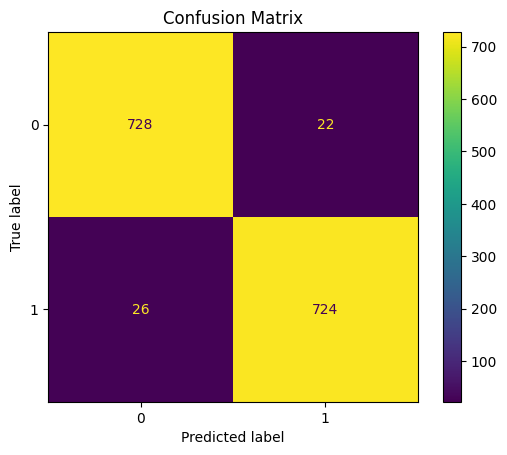

In [ ]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot the confusion matrix
cm_display.plot()
plt.title("Confusion Matrix")
plt.savefig("/kaggle/working/models/confusion_matrix.png");

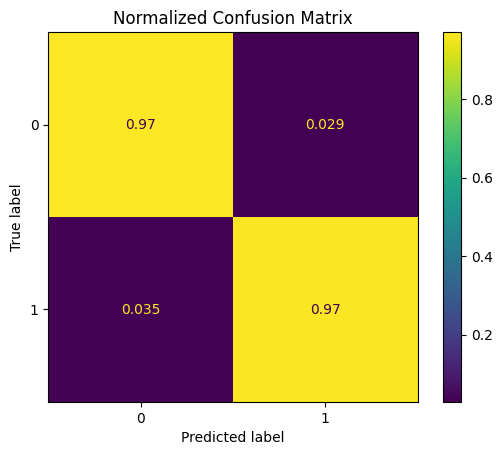

In [ ]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)

# plot the normalized confusion matrix
cm_display.plot()
plt.title("Normalized Confusion Matrix")
plt.savefig("/kaggle/working/models/normalized_confusion_matrix.png");

## Test with the new datasets

In [4]:
%cd /content/driver/MyDrive/Colab_Notebooks/Computer_Vision/Xception_Model/
!ls

/content/driver/MyDrive/Colab_Notebooks/Computer_Vision/Xception_Model
 2023-09-02_xception.h5
 2023-09-07_xception.h5
'Kaggle_Covid XRay Dataset'
'Kaggle_curated COVID19 chest Xray Dataset'
 test_confusion_matrix_1.png
 Test_confusion_matrix.png
 Test_normalized_confusion_matrix.png
 xception.ipynb
 xception_update.ipynb


In [5]:
Test_dir = './Kaggle_curated COVID19 chest Xray Dataset/'

In [9]:
model = tf.keras.models.load_model('./2023-09-07_xception.h5')

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255.0)

test_generator = test_datagen.flow_from_directory(Test_dir,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                class_mode='binary'
                                               )

Found 9208 images belonging to 2 classes.


In [11]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"\nTest Loss: {round(test_loss, 4)}")
print(f"Test Accuracy: {round(test_accuracy, 4)}")

144/144 [==============================] - 1702s 12s/step - loss: 0.0764 - accuracy: 0.9776

Test Loss: 0.0764
Test Accuracy: 0.9776


In [12]:
predicted = model.predict(test_generator, verbose=1)

144/144 [==============================] - 44s 299ms/step


In [13]:
true_classes = test_generator.classes
true_classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [14]:
predicted_classes = np.array([1 if coef >= 0.25 else 0 for coef in predicted])

In [15]:
report = classification_report(true_classes, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7927
           1       0.96      0.90      0.93      1281

    accuracy                           0.98      9208
   macro avg       0.97      0.95      0.96      9208
weighted avg       0.98      0.98      0.98      9208



In [16]:
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = confusion_matrix(true_classes, predicted_classes, normalize='true')
cm

array([[7879,   48],
       [ 124, 1157]])

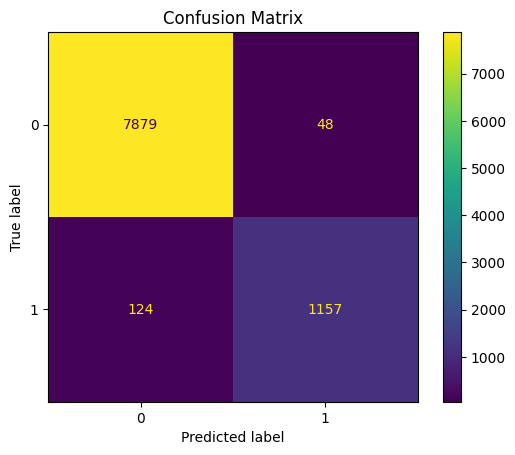

In [17]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot the confusion matrix
cm_display.plot()
plt.title("Confusion Matrix")
plt.savefig("./test_confusion_matrix_1.png");

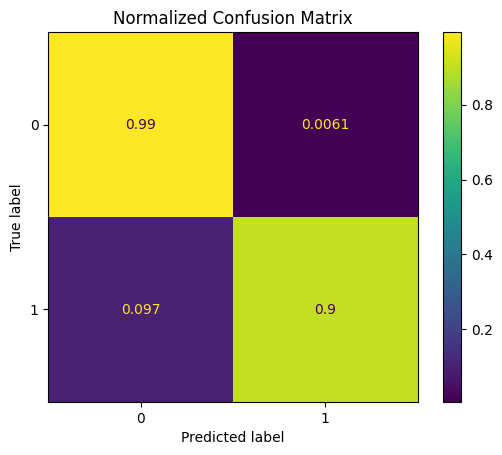

In [18]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)

# plot the normalized confusion matrix
cm_display.plot()
plt.title("Normalized Confusion Matrix")
plt.savefig("/test_normalized_confusion_matrix_1.png");